## Example usage of Tempestpy

In [1]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.logger import Logger, CSVOutputFormat, TensorBoardOutputFormat, HumanOutputFormat

import gymnasium as gym

from minigrid.core.actions import Actions
from minigrid.core.constants import TILE_PIXELS
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper

import tempfile, datetime, shutil

import time
import os

from utils import MiniGridShieldHandler, create_log_dir, ShieldingConfig, MiniWrapper, expname, shield_needed, shielded_evaluation, create_shield_overlay_image
from sb3utils import MiniGridSbShieldingWrapper, parse_sb3_arguments, ImageRecorderCallback, InfoCallback

import os, sys
from copy import deepcopy

from PIL import Image

pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-09-23 08:58:51.801230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 08:58:51.816264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 08:58:51.820526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 08:58:51.831659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 08:58:52.758922: W tensorflow/compiler/tf2

Starting the training


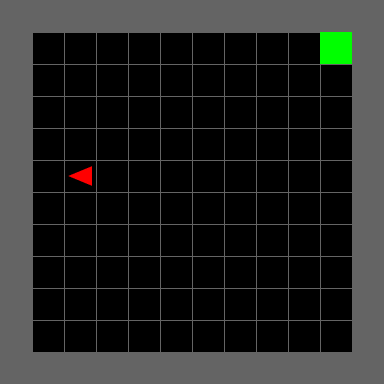



Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.0021867752075195312 seconds.
LOG: Starting with model checking...
Elapsed time is 0.00021076202392578125 seconds.
LOG: Starting to translate shield...
Elapsed time is 0.013784170150756836 seconds.


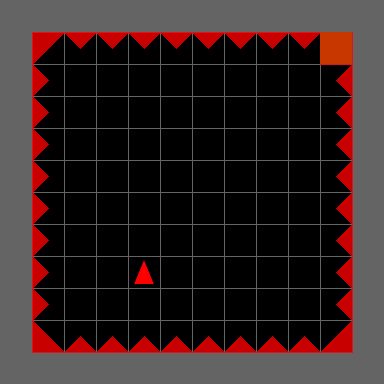

The shield for shield_value = 0.9


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.0031201839447021484 seconds.
LOG: Starting with model checking...
Elapsed time is 0.0002391338348388672 seconds.
LOG: Starting to translate shield...
Elapsed time is 0.013186454772949219 seconds.


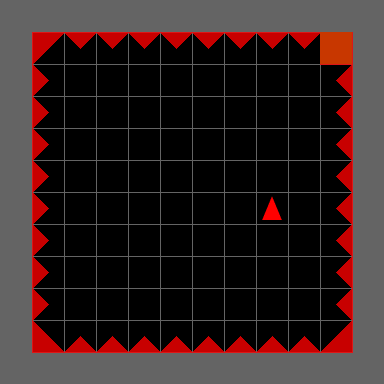

The shield for shield_value = 0.99


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.0027511119842529297 seconds.
LOG: Starting with model checking...
Elapsed time is 0.0002467632293701172 seconds.
LOG: Starting to translate shield...
Elapsed time is 0.014038324356079102 seconds.


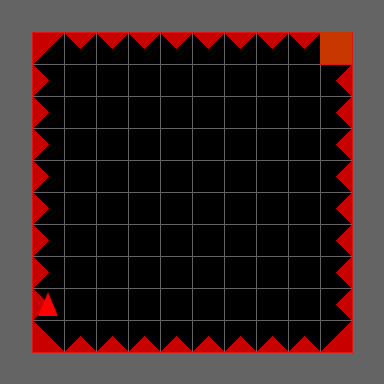

The shield for shield_value = 0.999


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.0026831626892089844 seconds.
LOG: Starting with model checking...
Elapsed time is 0.00027632713317871094 seconds.
LOG: Starting to translate shield...
Elapsed time is 0.013882875442504883 seconds.


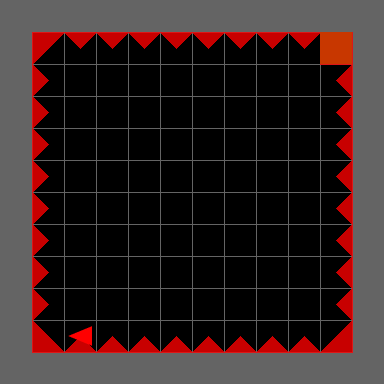

The shield for shield_value = 0.9999


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.002956867218017578 seconds.
LOG: Starting with model checking...
Elapsed time is 0.00025081634521484375 seconds.
LOG: Starting to translate shield...
Elapsed time is 0.014654159545898438 seconds.


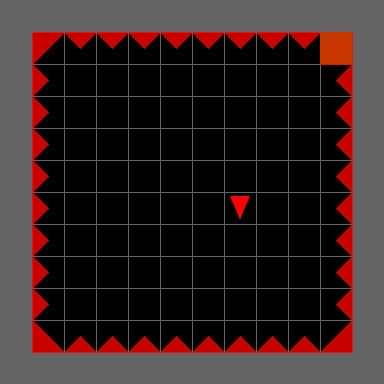

The shield for shield_value = 1.0


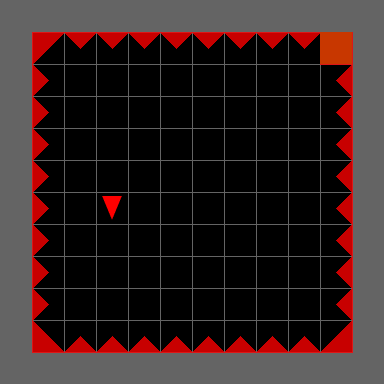

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
-----------------------------------
| info/                |          |
|    no_shield_action  | 0        |
|    sum_opened_door   | 0        |
|    sum_picked_up     | 0        |
|    sum_ran_into_lava | 0        |
|    sum_reached_goal  | 5        |
| rollout/             |          |
|    ep_len_mean       | 146      |
|    ep_rew_mean       | 0.357    |
| time/                |          |
|    fps               | 246      |
|    iterations        | 1        |
|    time_elapsed      | 8        |
|    total_timesteps   | 2048     |
-----------------------------------


In [ ]:
GRID_TO_PRISM_BINARY=os.getenv("M2P_BINARY")

def mask_fn(env: gym.Env):
    return env.create_action_mask()

def nomask_fn(env: gym.Env):
    return [1.0] * 7

def main():
    # Edit 'environments/Minigrid/minigrid/envs/GSW_Playground.py' to alter the environment
    env = "MiniGrid-GSW-v0"

    # TODO Change the safety specification
    formula = "Pmax=? [G true]"
    value_for_training = 1.0
    shield_comparison =  "absolute"
    shielding = ShieldingConfig.Training
    
    logger = Logger("/tmp", output_formats=[HumanOutputFormat(sys.stdout)])
    

    env = gym.make(env, render_mode="rgb_array")
    image_env = RGBImgObsWrapper(env, TILE_PIXELS)
    env = RGBImgObsWrapper(env, 8)
    env = ImgObsWrapper(env)
    env = MiniWrapper(env)

    
    env.reset()
    Image.fromarray(env.render()).show()
        
    shield_handlers = dict()
    if shield_needed(shielding):
        for value in [0.9, 0.99, 0.999, 0.9999, 1.0]:
            shield_handler = MiniGridShieldHandler(GRID_TO_PRISM_BINARY, "grid.txt", "grid.prism", formula, shield_value=value, shield_comparison=shield_comparison, nocleanup=False, prism_file=None)
            env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handler, create_shield_at_reset=False)
            create_shield_overlay_image(image_env, shield_handler.create_shield())
            print(f"The shield for shield_value = {value}")

            shield_handlers[value] = shield_handler


    if shielding == ShieldingConfig.Training:
        env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handler, create_shield_at_reset=False)
        env = ActionMasker(env, mask_fn
        print("Training with shield:")
        create_shield_overlay_image(image_env, shield_handlers[value_for_training].create_shield())
    elif shielding == ShieldingConfig.Disabled:
        env = ActionMasker(env, nomask_fn)
    else:
        assert(False) 
    model = MaskablePPO("CnnPolicy", env, verbose=1, device="auto")
    model.set_logger(logger)
    steps = 20_000

 
    model.learn(steps,callback=[InfoCallback()])



if __name__ == '__main__':
    print("Starting the training")
    main()